In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install statsmodels
!pip install daft-pgm
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.seasonal import STL

In [3]:
df = pd.read_csv("data/Assessment 2 - MMM Weekly.csv", parse_dates=["week"])

# Sort by time
df = df.sort_values("week").reset_index(drop=True)

# Create time features
df["week_num"] = df["week"].dt.isocalendar().week
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df["is_holiday"] = df["week"].dt.strftime('%Y-%m-%d').isin(["2023-12-25", "2024-01-01"]).astype(int)

In [4]:
# Handle zero-spend periods
media_channels = ["facebook_spend", "tiktok_spend", "snapchat_spend", "google_spend"]
for col in media_channels:
    df[f"{col}_active"] = (df[col] > 0).astype(int)
    df[col] = df[col].replace(0, np.nan)  # Temporarily treat zeros as missing

# Impute missing spend with small value
imputer = SimpleImputer(strategy="constant", fill_value=1e-3)
df[media_channels] = imputer.fit_transform(df[media_channels])

# Log-transform skewed variables
for col in media_channels + ["social_followers", "revenue"]:
    df[f"log_{col}"] = np.log1p(df[col])

# STL decomposition for trend/seasonality
stl = STL(df["revenue"], period=52)
res = stl.fit()
df["revenue_trend"] = res.trend
df["revenue_seasonal"] = res.seasonal
df["revenue_resid"] = res.resid

# Feature scaling
scaler = StandardScaler()
scaled_features = ["average_price", "promotions", "social_followers", "emails_send", "sms_send"]
df[[f"scaled_{col}" for col in scaled_features]] = scaler.fit_transform(df[scaled_features])

# Lag features (optional for modeling)
for col in ["revenue", "google_spend"]:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag2"] = df[col].shift(2)

# Drop rows with NaNs from lagging
df = df.dropna().reset_index(drop=True)

In [5]:
df

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,...,revenue_resid,scaled_average_price,scaled_promotions,scaled_social_followers,scaled_emails_send,scaled_sms_send,revenue_lag1,revenue_lag2,google_spend_lag1,google_spend_lag2
0,2023-10-01,5893.00,0.001,0.001,0.00,0.001,0,100.38,0,96797,...,-1.091394e-11,0.064580,-0.517970,-1.522971,-0.954353,-0.198984,373.02,83124.16,2704.000,3130.140
1,2023-10-08,7167.16,0.001,0.001,0.00,0.001,0,103.14,1,99098,...,-1.091394e-11,0.491502,1.930615,-1.522971,-0.862448,-1.425818,513.01,373.02,0.001,2704.000
2,2023-10-15,5360.29,0.001,0.001,3237.15,0.001,0,107.76,1,120754,...,1.818989e-11,1.206132,1.930615,-1.522971,0.002514,0.993155,452.78,513.01,0.001,0.001
3,2023-10-22,4195.29,3385.890,0.001,3438.69,0.001,0,102.55,0,116640,...,5.093170e-11,0.400239,-0.517970,-1.522971,-0.161804,0.329582,41441.95,452.78,0.001,0.001
4,2023-10-29,4788.44,4012.790,0.001,3103.79,838.750,0,107.29,0,109633,...,0.000000e+00,1.133432,-0.517970,-1.522971,-0.441670,-1.268937,141742.69,41441.95,3385.890,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2025-08-10,4103.29,0.001,2546.400,0.00,1987.810,137218,93.05,0,132583,...,0.000000e+00,-1.069239,-0.517970,1.362901,0.474976,0.385395,1177.78,1488.14,0.001,3837.160
98,2025-08-17,7929.61,0.001,3342.800,2410.68,1432.370,138794,96.91,0,92396,...,0.000000e+00,-0.472167,-0.517970,1.396047,-1.130133,2.458025,950.45,1177.78,0.001,0.001
99,2025-08-24,4090.74,0.001,0.001,2231.40,1666.770,140404,94.88,0,121519,...,-2.910383e-11,-0.786171,-0.517970,1.429907,0.033068,-1.026376,170470.10,950.45,0.001,0.001
100,2025-08-31,4116.70,0.001,0.001,782.06,0.001,141670,95.56,0,111165,...,0.000000e+00,-0.680987,-0.517970,1.456533,-0.380481,0.254611,193527.33,170470.10,0.001,0.001


In [6]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit

# Define predictors and target for Stage 1
X_social = df[["log_facebook_spend", "log_tiktok_spend", "log_snapchat_spend"]]
y_google = df["log_google_spend"]

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Ridge regression with cross-validated alpha
ridge_stage1 = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=tscv)
ridge_stage1.fit(X_social, y_google)

# Predict Google Spend (mediator)
df["log_google_hat"] = ridge_stage1.predict(X_social)

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define predictors for Stage 2
X_revenue = df[[
    "log_google_hat",  # mediated Google spend
    "scaled_average_price", "scaled_promotions", "scaled_emails_send", "scaled_sms_send",
    "revenue_trend", "revenue_seasonal", "log_social_followers"
]]
y_revenue = df["log_revenue"]

# Train/test split respecting time
train_size = int(len(df) * 0.8)
X_train, X_test = X_revenue[:train_size], X_revenue[train_size:]
y_train, y_test = y_revenue[:train_size], y_revenue[train_size:]

# Gradient Boosting for flexibility
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predictions and diagnostics
y_pred = gb_model.predict(X_test)

In [8]:
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 1.7234688675686192
R²: 0.6949068763560293


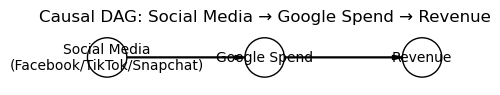

In [9]:
import daft
import matplotlib.pyplot as plt

# Create a PGM (Probabilistic Graphical Model)
pgm = daft.PGM()

# Add nodes: Social Media, Google Spend, Revenue
pgm.add_node("social", "Social Media\n(Facebook/TikTok/Snapchat)", 0, 1)
pgm.add_node("google", "Google Spend", 2, 1)
pgm.add_node("revenue", "Revenue", 4, 1)

# Add edges to reflect mediation
pgm.add_edge("social", "google")
pgm.add_edge("google", "revenue")
pgm.add_edge("social", "revenue")  # Optional direct path (dashed in concept)

# Render
pgm.render()
plt.title("Causal DAG: Social Media → Google Spend → Revenue")
plt.show()


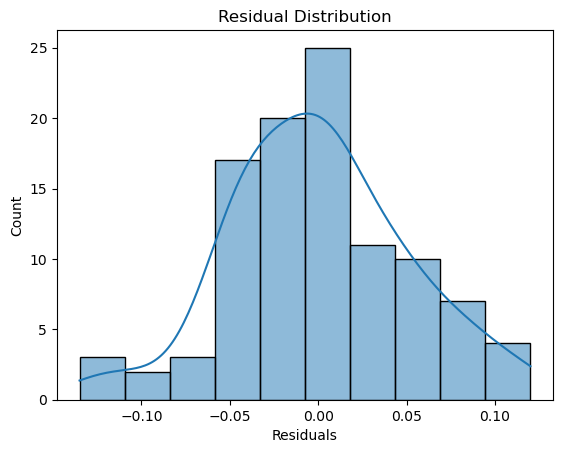

In [10]:
from sklearn.linear_model import RidgeCV

X_social = df[["log_facebook_spend", "log_tiktok_spend", "log_snapchat_spend"]]
y_google = df["log_google_spend"]

ridge_mediator = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_mediator.fit(X_social, y_google)

# Predicted mediator
df["log_google_hat"] = ridge_mediator.predict(X_social)

from sklearn.ensemble import GradientBoostingRegressor

X_revenue = df[[
    "log_google_hat",  # mediated Google spend
    "scaled_average_price", "scaled_promotions", "scaled_emails_send", "scaled_sms_send",
    "revenue_trend", "revenue_seasonal", "log_social_followers"
]]
y_revenue = df["log_revenue"]

gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
gb_model.fit(X_revenue, y_revenue)


import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_revenue - gb_model.predict(X_revenue)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

In [11]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Predictions
y_pred = gb_model.predict(X_test)

# Metrics
rmse = root_mean_squared_error(y_test, y_pred,)
r2 = r2_score(y_test, y_pred)

print(f"Out-of-Sample RMSE: {rmse:.3f}")
print(f"Out-of-Sample R²: {r2:.3f}")

Out-of-Sample RMSE: 0.043
Out-of-Sample R²: 1.000


In [12]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for train_idx, test_idx in tscv.split(X_revenue):
    X_train_cv, X_test_cv = X_revenue.iloc[train_idx], X_revenue.iloc[test_idx]
    y_train_cv, y_test_cv = y_revenue.iloc[train_idx], y_revenue.iloc[test_idx]
    
    model_cv = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)
    
    rmse_scores.append(root_mean_squared_error(y_test_cv, y_pred_cv))

print("Rolling CV RMSEs:", np.round(rmse_scores, 3))
print("Mean RMSE:", np.mean(rmse_scores))

Rolling CV RMSEs: [1.153 0.362 1.394 0.208 1.865]
Mean RMSE: 0.9962454954576694


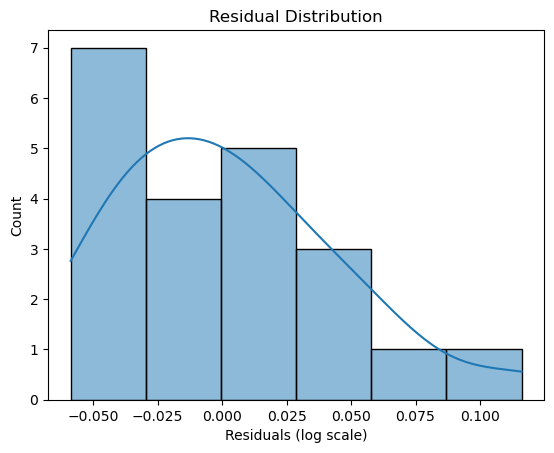

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

# Distribution
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals (log scale)")
plt.show()

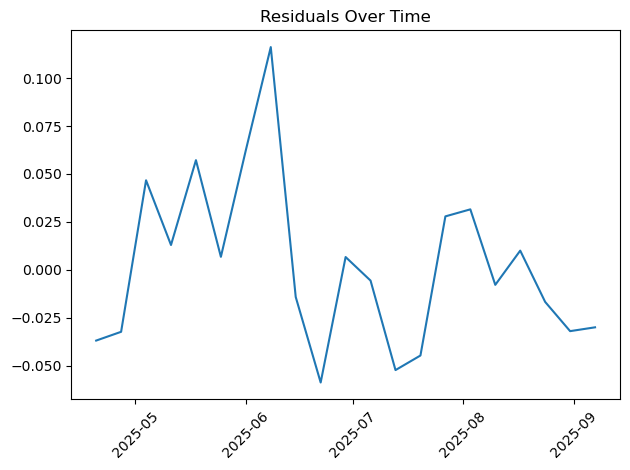

In [14]:
# Residuals over time
plt.plot(df["week"][train_size:], residuals)
plt.title("Residuals Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

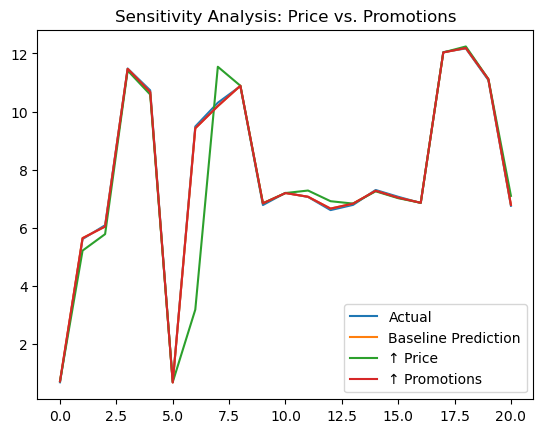

In [15]:
# Create a copy of test set
X_sensitivity = X_test.copy()

# Simulate 10% increase in price
X_sensitivity["scaled_average_price"] *= 1.1
y_price_up = gb_model.predict(X_sensitivity)

# Simulate 10% increase in promotions
X_sensitivity = X_test.copy()
X_sensitivity["scaled_promotions"] *= 1.1
y_promo_up = gb_model.predict(X_sensitivity)

# Plot effects
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Baseline Prediction")
plt.plot(y_price_up, label="↑ Price")
plt.plot(y_promo_up, label="↑ Promotions")
plt.legend()
plt.title("Sensitivity Analysis: Price vs. Promotions")
plt.show()

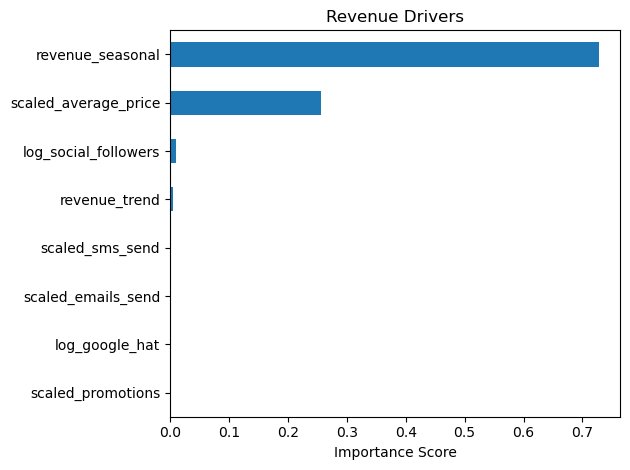

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance from Gradient Boosting
feature_importance = pd.Series(gb_model.feature_importances_, index=X_revenue.columns)
feature_importance.sort_values().plot(kind="barh", title="Revenue Drivers")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

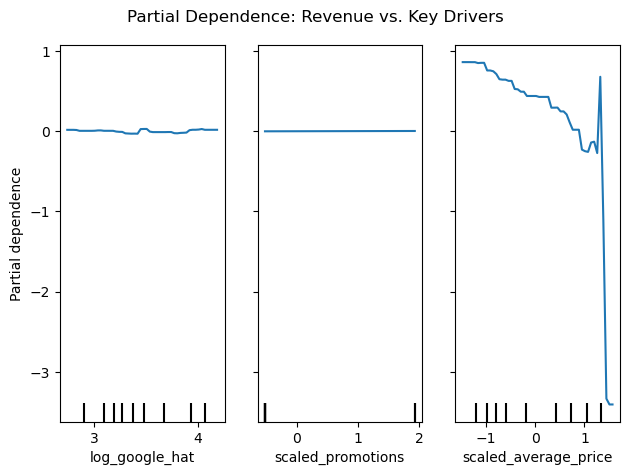

In [17]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    gb_model,
    X_revenue,
    features=["log_google_hat", "scaled_promotions", "scaled_average_price"],
    kind="average",
    grid_resolution=50
)
plt.suptitle("Partial Dependence: Revenue vs. Key Drivers")
plt.tight_layout()
plt.show()

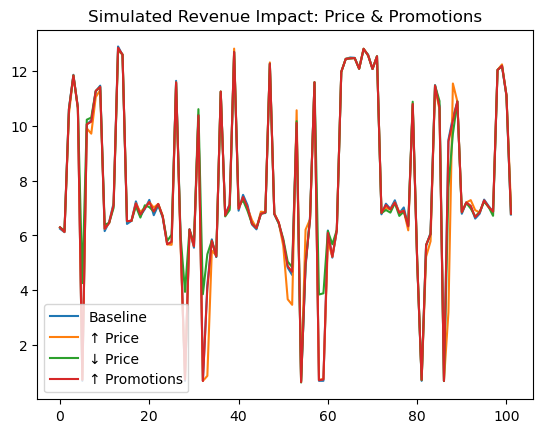

In [18]:
X_sim = X_revenue.copy()

# Simulate price increase
X_sim["scaled_average_price"] *= 1.1
rev_price_up = gb_model.predict(X_sim)

# Simulate price decrease
X_sim["scaled_average_price"] *= 0.9 / 1.1
rev_price_down = gb_model.predict(X_sim)

# Simulate promo increase
X_sim = X_revenue.copy()
X_sim["scaled_promotions"] *= 1.1
rev_promo_up = gb_model.predict(X_sim)

# Plot
plt.plot(y_revenue.values, label="Baseline")
plt.plot(rev_price_up, label="↑ Price")
plt.plot(rev_price_down, label="↓ Price")
plt.plot(rev_promo_up, label="↑ Promotions")
plt.legend()
plt.title("Simulated Revenue Impact: Price & Promotions")
plt.show()

In [19]:
# Check correlation matrix for collinearity
corr_matrix = df[["log_facebook_spend", "log_tiktok_spend", "log_snapchat_spend", "log_google_spend"]].corr()
print(corr_matrix)

                    log_facebook_spend  log_tiktok_spend  log_snapchat_spend  \
log_facebook_spend            1.000000          0.045605            0.075569   
log_tiktok_spend              0.045605          1.000000            0.149768   
log_snapchat_spend            0.075569          0.149768            1.000000   
log_google_spend             -0.104158         -0.038385            0.084916   

                    log_google_spend  
log_facebook_spend         -0.104158  
log_tiktok_spend           -0.038385  
log_snapchat_spend          0.084916  
log_google_spend            1.000000  
